# Step 1:  Find the best attributes to predict spirality and rank them

In [2]:
ModelRank = load("ModelforAnalysis.jld")["Model"]

Decision Tree
Leaves: 133546
Depth:  106

In [3]:
#ModelRank = build_tree(Ysum[train],fullDataSTD[train,:]);
#save("ModelforAnalysis.jld", "Model", ModelRank)

originalSTDOUT = STDOUT
(outRead, outWrite) = redirect_stdout()

(Base.PipeEndpoint(open, 0 bytes waiting),Base.PipeEndpoint(open, 0 bytes waiting))

In [4]:
print_tree(ModelRank,9)

In [5]:
close(outWrite)
treePrint = readavailable(outRead)
close(outRead)
redirect_stdout(originalSTDOUT)
treefile = open("ModelforAnalysis.txt", "a")
write(treefile, treePrint)
close(treefile)

In [6]:
f = open("ModelforAnalysis.txt")
lines = readlines(f)
close(f)

In [7]:
whitespac = matchall(r"\s*[LR]-> Fe+", string(lines))
featUnord = Int64[]
for e in [[parse(Int64,n) for n in matchall(r"[0-9]+", s)] for s in matchall(r" [0-9]+,", string(lines))]
    push!(featUnord, e[1])
end

levels = Int64[]
for i in whitespac
    push!(levels, div(length(i)-6,4))
end
levels = levels+2
levels = append!([1],levels)
rankedLevels = []

bestP = []
for i in 1:length(unique(levels))
    for j in findin(levels,i)
        push!(rankedLevels, i)
        push!(bestP, featUnord[j])
    end
end
uniqueInd = unique_indices(bestP)
bestP = unique(bestP)
rankedP = translate_to_names(bestP);

In [57]:
notBestP = []
for i in 1:size(fullDataSTD)[2]
    if !(i in bestP)
        push!(notBestP, i)
    end
end

In [52]:
for i in 1:length(rankedP)
    println(i, ": "rankedP[i], ", Level: ", (rankedLevels[uniqueInd])[i],", Pos: ", bestP[i])
end

println("\n\nThe Worst:")

println
for i in 1:length(notBestP)
    println(i+92, ": ", translate_to_names(notBestP[i])[1], ", Pos: ", notBestP[i])
end


1: numArcsGE090, Level: 1, Pos: 99
2: totalArcLength, Level: 2, Pos: 78
3: diskMinAxsLen, Level: 2, Pos: 60
4: g_r, Level: 3, Pos: 46
5: deVAB_i, Level: 3, Pos: 13
6: texture_i, Level: 3, Pos: 22
7: petroR50_g, Level: 4, Pos: 1
8: petroR90_g_to_petroR50_g_ratio, Level: 4, Pos: 49
9: rest_ug, Level: 4, Pos: 31
10: lnLexp_i, Level: 4, Pos: 15
11: numDcoArcsGE120, Level: 4, Pos: 123
12: alenAt25pct, Level: 5, Pos: 71
13: expAB_i, Level: 5, Pos: 14
14: brtUnifScore, Level: 5, Pos: 66
15: sorted_agreeing_pangs_pt1, Level: 5, Pos: 133
16: wtdLik, Level: 6, Pos: 64
17: lnLdeV_i, Level: 6, Pos: 16
18: MR, Level: 6, Pos: 42
19: avgArcLength, Level: 6, Pos: 77
20: nnAvgZ, Level: 6, Pos: 29
21: alenAt50pct, Level: 6, Pos: 72
22: lnLstar_i, Level: 6, Pos: 17
23: petroR90_r_to_petroR50_r_ratio, Level: 7, Pos: 51
24: numDcoArcsGE060, Level: 7, Pos: 116
25: r_i, Level: 7, Pos: 47
26: kcorr_u, Level: 7, Pos: 35
27: pa_alenWtd_avg__abs, Level: 7, Pos: 81
28: MG, Level: 7, Pos: 41
29: kcorr_i, Level: 7,

# Step 2 Use the best "x" number of parameters to build a Model that does as close as possible to the best values we had on predicting H_SP:

    Ensemble of Decision Trees
    Trees:      35
    Avg Leaves: 184301.62857142856
    Avg Depth:  66.91428571428571
    Features: 60
    RMSE: 0.13685871885481865
    Pearson Correlation: 0.8275413973816701

## 1. Try the top 16

In [9]:
#featuresPos = collect(1:16)
# num_of_features = length(featuresPos);
# fullDataSTDReduced = zeros(size(fullDataSTD)[1],length(featuresPos))
# for (i,j) in zip(1:num_of_features, featuresPos)
#     fullDataSTDReduced[:,i] = fullDataSTD[:,bestP[j][1]]
# end
num_of_features = 16;
fullDataSTDReduced = zeros(size(fullDataSTD)[1],num_of_features)
for i in 1:num_of_features
    fullDataSTDReduced[:,i] = fullDataSTD[:,bestP[i]]
end

In [ ]:
num_of_trees = collect(5:5:100);
RMSETe = zeros(length(num_of_trees))
PredictionsTe = zeros(length(num_of_trees),size(fullDataSTDReduced[!train,:])[1])
PCTe = zeros(length(num_of_trees))
CM = DataFrame[]
for i in 1:length(num_of_trees)
    println("\n\n")
    display(Dates.format(now(), "e, dd u yyyy HH:MM"))
    @time ModelReduced1 = build_forest(Ysum[train],fullDataSTDReduced[train,:],num_of_features,num_of_trees[i]);
    println("\n", ModelReduced1)
    println("Using the $num_of_features best features")
    println("Test dataset: $(length(Ysum[!train])) elements")
    PredictionsTe[i,:] = apply_forest(ModelReduced1, fullDataSTDReduced[!train,:]);
    RMSETe[i] = root_mean_squared_error(Ysum[!train,:], PredictionsTe[i,:]');
    println("RMSE: ",RMSETe[i])
    PCTe[i] = cor(Ysum[!train,:],PredictionsTe[i,:]')[1]
    println("Pearson Correlation: ", PCTe[i], "\n")
    push!(CM, confusion_matrix_regression(Ysum[!train],PredictionsTe[i,:]',10))
end

"Mon, 02 May 2016 11:54"




266.696877 seconds (110.62 M allocations: 21.103 GB, 6.48% gc time)

Ensemble of Decision Trees
Trees:      5
Avg Leaves: 89932.8
Avg Depth:  56.4
Using the 16 best features
Test dataset: 91487 elements
RMSE: 

"Mon, 02 May 2016 11:59"

0.1419765586338362
Pearson Correlation: 0.8146786785257981




1579.539801 seconds (553.22 M allocations: 105.193 GB, 15.83% gc time)

Ensemble of Decision Trees
Trees:      25
Avg Leaves: 89952.76
Avg Depth:  58.32
Using the 16 best features
Test dataset: 91487 elements
RMSE: 

"Mon, 02 May 2016 13:09"

0.14140722294635402
Pearson Correlation: 0.8163421785990028




1823.734504 seconds (663.80 M allocations: 126.322 GB, 18.04% gc time)

Ensemble of Decision Trees
Trees:      30
Avg Leaves: 89942.0
Avg Depth:  57.63333333333333
Using the 16 best features
Test dataset: 91487 elements


"Mon, 02 May 2016 13:40"

RMSE: 0.14091053821264277
Pearson Correlation: 0.8177986961773046




2345.482801 seconds (774.33 M allocations: 147.310 GB, 21.65% gc time)

Ensemble of Decision Trees
Trees:      35
Avg Leaves: 89929.02857142857
Avg Depth:  58.65714285714286
Using the 16 best features
Test dataset: 91487 elements


"Mon, 02 May 2016 14:20"

RMSE: 0.14083869623848658
Pearson Correlation: 0.8180058936576471




2880.833328 seconds (885.24 M allocations: 168.426 GB, 24.26% gc time)

Ensemble of Decision Trees
Trees:      40
Avg Leaves: 89960.45
Avg Depth:  59.35
Using the 16 best features
Test dataset: 91487 elements
RMSE: 

"Mon, 02 May 2016 15:08"

RMSE: 0.13983962031036323
Pearson Correlation: 0.8208943418986672




4244.300619 seconds (1.33 G allocations: 252.625 GB, 27.64% gc time)

Ensemble of Decision Trees
Trees:      60
Avg Leaves: 89935.58333333333
Avg Depth:  58.46666666666667
Using the 16 best features
Test dataset: 91487 elements
RMSE: 

"Mon, 02 May 2016 19:23"

0.13952912339418716
Pearson Correlation: 0.8217991274775187




4731.625793 seconds (1.44 G allocations: 273.680 GB, 29.44% gc time)

Ensemble of Decision Trees
Trees:      65
Avg Leaves: 89942.55384615385
Avg Depth:  58.6
Using the 16 best features
Test dataset: 91487 elements


"Mon, 02 May 2016 20:43"

0.13946740858219084
Pearson Correlation: 0.8219815083686869




5894.453200 seconds (1.66 G allocations: 315.632 GB, 34.74% gc time)

Ensemble of Decision Trees
Trees:      75
Avg Leaves: 89939.13333333333
Avg Depth:  58.53333333333333
Using the 16 best features
Test dataset: 91487 elements
RMSE: 

"Mon, 02 May 2016 23:57"

RMSE: 0.1393679352030898
Pearson Correlation: 0.8222751076816781




8313.983198 seconds (2.10 G allocations: 399.780 GB, 41.67% gc time)

Ensemble of Decision Trees
Trees:      95
Avg Leaves: 89973.34736842105
Avg Depth:  57.71578947368421
Using the 16 best features
Test dataset: 91487 elements
RMSE: 

"Tue, 03 May 2016 08:03"

In [39]:
RMSETeSTP2 = deepcopy(RMSETe)
PredictionsTeSTP2 = deepcopy(PredictionsTe)
PCTeSTP2 = deepcopy(PCTe);

20-element Array{Float64,1}:
 0.7874  
 0.804458
 0.810141
 0.814679
 0.816342
 0.817799
 0.818006
 0.819976
 0.82019 
 0.820646
 0.820894
 0.821799
 0.821436
 0.821982
 0.822319
 0.822337
 0.82281 
 0.822275
 0.822517
 0.822847

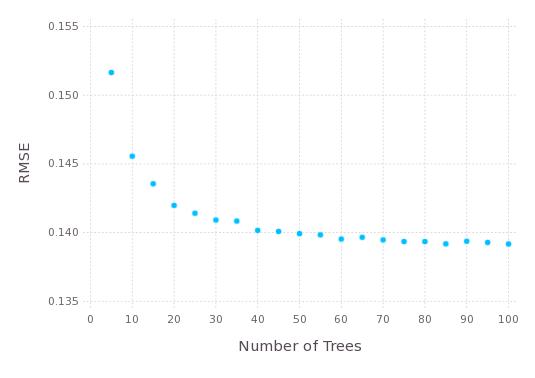

In [40]:
plot(x=num_of_trees, y=RMSETeSTP2, Guide.ylabel("RMSE"), Guide.xlabel("Number of Trees"), Stat.xticks(ticks=collect(0:10:100)), Geom.point)

In [78]:
save("Stetp2Data.jld", "ConfusionMatrix", CM, "Predictions", PredictionsTeSTP2, "RMSETe", RMSETeSTP2, "PCTe", PCTeSTP2, "Trees", num_of_trees)

## 2. Try this list:
* 1: numArcsGE090 (99,-20369.321423323323,0.2188434965148634)
* 5: numDcoArcsGE085 (119,-20432.942065926225,1.3722285952948055)
* 17: totalArcLength (78,-21096.22699232725,0.1942439497930205)
* 23: alenAt25pct (71,-21555.39264206979,0.5405004113848259)
* 24: bar_cand_score_orifld (88,-21738.29434596205,0.48102148306051484)
* 27: petroR50_g (1,-22072.843747045725,0.014530657489015993)
* 29: petroR90_g_to_petroR50_g_ratio (49,-22304.476234843984,-0.471052449934605)
* 40: lnLdeV_i (16,-22963.877131030473,0.0014779156992042598)
* 42: MRrCc_i (20,-23001.034327451816,-0.09140341857522755)
* 43: g_r (46,-23154.77510737102,0.26432225304753676)
* 44: avgArcLength (77,-23208.47113405211,0.2794371952818688)
* 45: rest_gr (32,-23239.43076260251,0.3930703871706166)

If it sucks, then perhaps add in a few more from the (1) list.

In [12]:
featuresPos = [1,5,17,23,24,27,29,40,42,43,44,45]
num_of_features = length(featuresPos);
fullDataSTDReduced = zeros(size(fullDataSTD)[1],length(featuresPos))
for (i,j) in zip(1:num_of_features, featuresPos)
    fullDataSTDReduced[:,i] = fullDataSTD[:,bestP[j][1]]
end

In [13]:
num_of_trees = collect(50:5:100);
for i in 1:length(num_of_trees)
    display(Dates.format(now(), "e, dd u yyyy HH:MM"))
    @time ModelReduced2 = build_forest(Ysum[train],fullDataSTDReduced[train,:],num_of_features,num_of_trees[i]);
    println("\n", ModelReduced2)
    println("Using the $num_of_features best features")
    PredictionsTe2 = apply_forest(ModelReduced2, fullDataSTDReduced[!train,:]);
    RMSETe2 = root_mean_squared_error(Ysum[!train,:], PredictionsTe2);
    println("Test dataset: $(length(Ysum[!train])) elements")
    println("RMSE: ",RMSETe2)
    println("Pearson Correlation: ", cor(Ysum[!train,:],PredictionsTe2)[1])
    display(confusion_matrix_regression(Ysum[!train],PredictionsTe2,10))
end

"Wed, 09 Mar 2016 19:34"

RMSE: 0.19086428268007338
Pearson Correlation: 0.6270102218382666

2101.541201 seconds (3.60 G allocations: 381.108 GB, 25.42% gc time)

Ensemble of Decision Trees
Trees:      50
Avg Leaves: 184614.94
Avg Depth:  54.54
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43685,8618,2688,1042,389,141,58,16,6,0,56643
2,4600,3942,2342,1129,533,203,90,28,10,1,12878
3,806,1533,1427,968,546,271,130,36,15,0,5732
4,240,654,869,685,419,265,113,71,24,4,3344
5,100,359,526,511,418,267,136,59,27,1,2404
6,74,250,350,429,358,268,177,90,34,9,2039
7,43,135,250,316,326,261,182,109,49,18,1689
8,23,85,218,302,296,290,223,148,81,16,1682
9,10,61,144,233,312,342,308,227,147,60,1844
10,2,43,78,119,247,373,489,521,641,560,3073


"Wed, 09 Mar 2016 20:35"

RMSE: 0.1475391166473876
Pearson Correlation: 0.7982451234612198
3298.222723 seconds (3.96 G allocations: 419.671 GB, 46.07% gc time)

Ensemble of Decision Trees
Trees:      55
Avg Leaves: 184598.0909090909
Avg Depth:  54.89090909090909
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43649,8668,2691,1005,402,149,61,15,3,0,56643
2,4572,3961,2345,1127,536,215,84,29,7,2,12878
3,788,1570,1449,935,513,307,113,41,16,0,5732
4,237,679,836,700,419,264,128,52,24,5,3344
5,98,368,506,540,400,281,119,70,18,4,2404
6,67,257,350,419,369,261,182,93,33,8,2039
7,41,137,262,318,315,260,188,100,51,17,1689
8,25,86,214,302,310,264,240,145,80,16,1682
9,10,65,130,225,333,331,317,229,144,60,1844
10,4,30,78,122,262,350,482,534,642,569,3073


"Wed, 09 Mar 2016 22:40"

RMSE: 0.14727097699111946
Pearson Correlation: 0.799086788264859
3697.505497 seconds (4.32 G allocations: 457.560 GB, 48.33% gc time)

Ensemble of Decision Trees
Trees:      60
Avg Leaves: 184592.6
Avg Depth:  54.266666666666666
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43586,8721,2702,1013,399,142,58,16,5,1,56643
2,4611,3966,2293,1133,533,222,84,27,6,3,12878
3,785,1590,1434,947,518,278,128,41,11,0,5732
4,240,643,853,686,448,270,109,65,28,2,3344
5,94,365,511,542,408,268,128,62,22,4,2404
6,79,240,366,403,375,276,177,73,40,10,2039
7,42,141,256,314,321,271,172,99,57,16,1689
8,24,84,212,308,293,286,223,153,84,15,1682
9,9,65,142,220,321,340,325,209,155,58,1844
10,1,37,72,126,250,356,495,540,625,571,3073


"Wed, 09 Mar 2016 23:42"

RMSE: 0.14715372738196578
Pearson Correlation: 0.7994514131803953
4252.874769 seconds (4.68 G allocations: 495.532 GB, 50.06% gc time)

Ensemble of Decision Trees
Trees:      65
Avg Leaves: 184608.21538461538
Avg Depth:  54.41538461538462
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43729,8589,2715,995,397,144,53,18,3,0,56643
2,4595,3909,2359,1161,525,205,88,26,7,3,12878
3,804,1556,1477,898,556,277,106,45,13,0,5732
4,234,668,857,685,438,253,130,48,26,5,3344
5,97,354,544,495,447,243,140,64,16,4,2404
6,70,250,378,399,361,271,176,91,33,10,2039
7,42,139,260,311,326,264,172,107,48,20,1689
8,27,84,214,311,283,289,218,160,78,18,1682
9,9,69,145,238,289,331,335,217,155,56,1844
10,3,38,71,125,251,371,483,516,641,574,3073


"Thu, 10 Mar 2016 00:53"

RMSE: 0.14714425455706487
Pearson Correlation: 0.799466406222187
4698.757787 seconds (5.04 G allocations: 533.988 GB, 51.62% gc time)

Ensemble of Decision Trees
Trees:      70
Avg Leaves: 184588.6857142857
Avg Depth:  54.714285714285715
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43735,8589,2717,992,406,128,48,22,5,1,56643
2,4587,3939,2355,1141,531,201,89,25,10,0,12878
3,800,1561,1454,953,511,279,120,41,13,0,5732
4,239,649,867,690,441,239,140,49,27,3,3344
5,94,358,522,526,414,279,125,65,16,5,2404
6,76,228,386,401,368,280,171,81,39,9,2039
7,39,135,254,331,306,278,185,97,51,13,1689
8,27,77,214,309,303,273,229,151,81,18,1682
9,9,67,135,234,310,345,309,227,153,55,1844
10,1,38,79,120,261,361,478,534,640,561,3073


"Thu, 10 Mar 2016 02:12"

RMSE: 0.14681762816322633
Pearson Correlation: 0.8004928445965293
4880.539028 seconds (5.40 G allocations: 572.233 GB, 53.22% gc time)

Ensemble of Decision Trees
Trees:      75
Avg Leaves: 184600.86666666667
Avg Depth:  55.32
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43669,8655,2708,999,400,136,51,21,4,0,56643
2,4620,3922,2324,1143,537,205,95,23,8,1,12878
3,790,1568,1441,956,508,291,129,37,12,0,5732
4,238,678,835,712,413,266,116,52,31,3,3344
5,102,346,527,533,410,270,134,58,21,3,2404
6,73,228,365,428,375,266,171,91,33,9,2039
7,43,130,264,326,316,263,184,95,50,18,1689
8,26,87,208,302,300,296,224,140,86,13,1682
9,10,62,129,246,323,337,295,234,150,58,1844
10,3,38,75,133,251,359,490,513,649,562,3073


"Thu, 10 Mar 2016 03:34"

RMSE: 0.14697400107676012
Pearson Correlation: 0.8000025949756046
5390.425577 seconds (5.76 G allocations: 610.439 GB, 54.68% gc time)

Ensemble of Decision Trees
Trees:      80
Avg Leaves: 184595.475
Avg Depth:  53.9
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43661,8685,2662,1026,393,151,42,18,5,0,56643
2,4590,3956,2317,1156,523,210,86,30,7,3,12878
3,787,1596,1413,976,501,286,124,37,12,0,5732
4,236,667,854,691,443,249,121,56,24,3,3344
5,99,342,534,525,409,272,140,56,23,4,2404
6,69,242,371,418,353,275,189,80,33,9,2039
7,42,136,260,319,320,278,161,103,53,17,1689
8,21,87,217,298,300,291,221,151,78,18,1682
9,8,63,148,228,312,340,306,232,146,61,1844
10,5,34,69,126,277,327,508,509,628,590,3073


"Thu, 10 Mar 2016 05:05"

RMSE: 0.14685193449799172
Pearson Correlation: 0.8003860681587808
5916.694803 seconds (6.12 G allocations: 648.161 GB, 56.17% gc time)

Ensemble of Decision Trees
Trees:      85
Avg Leaves: 184587.37647058823
Avg Depth:  54.294117647058826
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43711,8610,2732,987,395,134,55,17,2,0,56643
2,4559,3987,2334,1161,511,195,100,18,12,1,12878
3,784,1564,1489,894,547,291,110,39,14,0,5732
4,231,672,879,674,434,268,104,56,22,4,3344
5,99,339,540,534,417,262,128,63,17,5,2404
6,70,234,392,390,380,265,175,87,37,9,2039
7,45,134,248,330,312,274,178,101,50,17,1689
8,25,76,222,298,303,297,220,141,81,19,1682
9,10,64,145,210,320,342,326,213,155,59,1844
10,3,42,72,121,256,355,481,518,654,571,3073


"Thu, 10 Mar 2016 06:44"

RMSE: 0.14667794765595688
Pearson Correlation: 0.8009148621089553
6470.646083 seconds (6.48 G allocations: 686.218 GB, 57.49% gc time)

Ensemble of Decision Trees
Trees:      90
Avg Leaves: 184554.6888888889
Avg Depth:  54.955555555555556
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43720,8606,2697,1017,396,138,47,18,4,0,56643
2,4555,3955,2351,1175,519,198,90,26,7,2,12878
3,769,1582,1469,940,526,272,124,37,12,1,5732
4,225,678,868,674,431,268,112,56,28,4,3344
5,103,342,521,529,425,267,135,56,22,4,2404
6,73,226,394,386,388,272,167,91,34,8,2039
7,46,132,258,325,321,269,171,99,54,14,1689
8,28,82,216,297,324,265,218,150,88,14,1682
9,13,58,141,225,322,349,318,213,155,50,1844
10,3,39,71,125,266,370,482,532,623,562,3073


"Thu, 10 Mar 2016 08:33"

RMSE: 0.1468892492815455
Pearson Correlation: 0.8002882920146737
7033.990366 seconds (6.84 G allocations: 724.230 GB, 58.77% gc time)

Ensemble of Decision Trees
Trees:      95
Avg Leaves: 184604.8
Avg Depth:  54.73684210526316
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43744,8571,2741,991,388,135,55,15,3,0,56643
2,4527,3991,2325,1165,542,203,86,29,7,3,12878
3,804,1517,1484,956,525,273,124,36,13,0,5732
4,238,668,860,671,442,270,109,57,25,4,3344
5,96,355,531,522,415,265,148,46,23,3,2404
6,68,235,381,413,352,288,173,85,36,8,2039
7,43,128,275,300,327,272,179,95,50,20,1689
8,24,84,205,319,302,277,226,153,78,14,1682
9,10,61,141,226,321,340,306,225,161,53,1844
10,2,42,71,115,266,344,515,494,650,574,3073


"Thu, 10 Mar 2016 10:31"

RMSE: 0.14674891205416143
Pearson Correlation: 0.8007069764340122
8049.499465 seconds (7.20 G allocations: 762.740 GB, 60.30% gc time)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 184593.56
Avg Depth:  54.34
Using the 12 best features
Test dataset: 91328 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43691,8639,2736,976,395,134,51,16,4,1,56643
2,4573,3946,2358,1160,522,200,83,28,5,3,12878
3,776,1568,1473,955,509,278,119,41,13,0,5732
4,238,651,885,683,431,250,120,55,29,2,3344
5,102,336,532,523,418,266,145,60,18,4,2404
6,68,237,377,408,373,273,168,92,35,8,2039
7,42,133,267,315,310,281,179,95,54,13,1689
8,27,82,212,312,311,265,226,148,81,18,1682
9,13,58,148,225,312,340,318,225,142,63,1844
10,3,38,72,117,267,351,493,533,628,571,3073


RMSE: 0.1466925516140018
Pearson Correlation: 0.8008815303664262


In [15]:
num_of_trees = collect(5:5:50);
for i in 1:length(num_of_trees)
    display(Dates.format(now(), "e, dd u yyyy HH:MM"))
    @time ModelReduced2 = build_forest(Ysum[train],fullDataSTDReduced[train,:],num_of_features,num_of_trees[i]);
    println("\n", ModelReduced2)
    println("Using the $num_of_features best features")
    PredictionsTe2 = apply_forest(ModelReduced2, fullDataSTDReduced[!train,:]);
    RMSETe2 = root_mean_squared_error(Ysum[!train,:], PredictionsTe2);
    println("Test dataset: $(length(Ysum[!train])) elements")
    println("RMSE: ",RMSETe2)
    println("Pearson Correlation: ", cor(Ysum[!train,:],PredictionsTe2)[1])
    display(confusion_matrix_regression(Ysum[!train],PredictionsTe2,10))
end

"Mon, 07 Mar 2016 19:34"

181.138444 seconds (360.06 M allocations: 38.182 GB, 11.04% gc time)

Ensemble of Decision Trees
Trees:      5
Avg Leaves: 184529.0
Avg Depth:  57.6
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43793,8022,2881,1202,572,251,108,32,22,3,56886
2,5264,3477,1968,1093,600,267,131,56,26,8,12890
3,1064,1445,1122,811,483,318,163,84,35,8,5533
4,399,682,674,579,394,270,169,88,38,7,3300
5,187,388,419,425,330,247,151,103,44,21,2315
6,126,293,352,358,291,250,183,102,67,31,2053
7,76,182,251,298,265,211,177,110,75,43,1688
8,42,133,173,244,263,238,203,151,111,53,1611
9,39,99,157,227,263,271,269,247,187,110,1869
10,21,57,96,170,234,312,419,478,588,742,3117


"Mon, 07 Mar 2016 19:37"

RMSE: 0.16083837910524337
Pearson Correlation: 0.7591026302930697
393.294403 seconds (720.88 M allocations: 76.364 GB, 17.37% gc time)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 184703.6
Avg Depth:  53.7
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43789,8460,2790,1076,447,208,76,28,9,3,56886
2,4985,3657,2165,1123,564,233,110,41,9,3,12890
3,925,1476,1282,845,510,281,129,65,18,2,5533
4,293,681,751,632,426,254,152,68,34,9,3300
5,140,354,488,458,357,243,135,91,41,8,2315
6,99,253,361,378,359,270,161,99,58,15,2053
7,62,167,250,299,315,223,193,104,47,28,1688
8,37,101,169,282,304,233,190,175,95,25,1611
9,17,94,156,205,287,312,299,234,191,74,1869
10,14,37,98,160,255,281,436,565,607,664,3117


"Mon, 07 Mar 2016 19:44"

RMSE: 0.1530621049501593
Pearson Correlation: 0.7819824243915167
609.037998 seconds (1.08 G allocations: 114.392 GB, 21.96% gc time)

Ensemble of Decision Trees
Trees:      15
Avg Leaves: 184715.33333333334
Avg Depth:  54.6
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43725,8562,2831,1066,453,159,55,24,9,2,56886
2,4808,3854,2228,1129,511,211,98,37,13,1,12890
3,849,1516,1293,871,514,287,123,59,18,3,5533
4,289,662,779,610,463,263,143,65,24,2,3300
5,120,370,467,484,359,251,146,77,31,10,2315
6,87,244,357,410,353,273,189,82,44,14,2053
7,51,140,264,348,287,249,162,108,52,27,1688
8,31,102,187,257,309,253,194,160,89,29,1611
9,16,77,166,223,286,318,307,252,154,70,1869
10,16,34,79,149,256,330,473,528,605,647,3117


"Mon, 07 Mar 2016 19:54"

RMSE: 0.1506954593076059
Pearson Correlation: 0.7890912444328324
871.010663 seconds (1.44 G allocations: 152.657 GB, 26.21% gc time)

Ensemble of Decision Trees
Trees:      20
Avg Leaves: 184556.65
Avg Depth:  54.5
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43724,8646,2759,1102,426,146,53,23,6,1,56886
2,4748,3899,2252,1118,525,216,88,35,7,2,12890
3,821,1517,1319,893,542,266,112,52,8,3,5533
4,269,701,747,683,419,268,118,63,28,4,3300
5,118,368,505,464,371,222,155,78,28,6,2315
6,72,263,348,420,354,288,158,97,36,17,2053
7,48,161,236,323,305,254,186,106,45,24,1688
8,32,84,175,260,313,272,228,143,85,19,1611
9,15,78,140,237,280,317,329,248,167,58,1869
10,10,38,78,152,248,346,432,531,646,636,3117


"Mon, 07 Mar 2016 20:09"

RMSE: 0.1489951951177826
Pearson Correlation: 0.7943019466093789
1129.483176 seconds (1.80 G allocations: 190.855 GB, 30.25% gc time)

Ensemble of Decision Trees
Trees:      25
Avg Leaves: 184600.04
Avg Depth:  54.64
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43755,8664,2793,1055,393,144,54,16,11,1,56886
2,4741,3894,2295,1129,501,204,74,43,8,1,12890
3,810,1491,1352,911,516,263,134,42,12,2,5533
4,264,680,771,671,428,267,126,65,24,4,3300
5,112,370,472,496,366,225,150,90,29,5,2315
6,71,261,359,409,372,255,181,90,45,10,2053
7,47,144,248,355,296,246,179,110,39,24,1688
8,24,97,159,288,318,240,222,165,81,17,1611
9,14,83,130,230,304,321,313,243,176,55,1869
10,12,37,76,137,255,344,474,519,666,597,3117


"Mon, 07 Mar 2016 20:28"

RMSE: 0.1483829089913182
Pearson Correlation: 0.7962061341423929
1437.151438 seconds (2.16 G allocations: 228.966 GB, 33.81% gc time)

Ensemble of Decision Trees
Trees:      30
Avg Leaves: 184657.23333333334
Avg Depth:  54.266666666666666
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43704,8695,2790,1071,403,146,44,21,10,2,56886
2,4736,3889,2258,1164,510,215,74,32,10,2,12890
3,788,1538,1334,904,532,243,136,46,9,3,5533
4,250,665,821,635,443,268,133,64,17,4,3300
5,113,368,487,457,394,241,137,78,31,9,2315
6,75,250,376,399,360,278,182,85,35,13,2053
7,40,156,263,314,325,254,162,99,55,20,1688
8,29,77,185,271,316,243,240,151,81,18,1611
9,7,88,142,217,288,335,326,241,175,50,1869
10,11,33,73,138,282,336,439,552,659,594,3117


"Mon, 07 Mar 2016 20:52"

RMSE: 0.14818380938533227
Pearson Correlation: 0.796831751748438
1758.688160 seconds (2.52 G allocations: 267.200 GB, 36.97% gc time)

Ensemble of Decision Trees
Trees:      35
Avg Leaves: 184658.7142857143
Avg Depth:  54.457142857142856
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43755,8693,2786,1074,368,138,41,26,5,0,56886
2,4723,3888,2273,1171,517,201,70,37,8,2,12890
3,803,1507,1342,922,535,249,124,39,11,1,5533
4,257,671,812,636,452,271,126,48,19,8,3300
5,119,343,491,491,386,232,146,77,25,5,2315
6,59,264,374,407,371,266,182,74,45,11,2053
7,46,130,275,324,323,243,188,90,48,21,1688
8,23,81,174,283,300,282,223,151,81,13,1611
9,13,73,145,213,311,310,323,266,165,50,1869
10,8,33,81,150,241,348,467,535,639,615,3117


"Mon, 07 Mar 2016 21:22"

RMSE: 0.14743422799041545
Pearson Correlation: 0.7991299324987835
2180.643086 seconds (2.88 G allocations: 305.441 GB, 39.93% gc time)

Ensemble of Decision Trees
Trees:      40
Avg Leaves: 184639.275
Avg Depth:  54.125
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43752,8694,2798,1033,387,149,45,18,9,1,56886
2,4688,3976,2300,1108,489,211,79,31,7,1,12890
3,772,1538,1341,912,527,269,111,52,10,1,5533
4,246,676,806,637,460,268,124,64,13,6,3300
5,107,358,490,478,395,237,144,74,25,7,2315
6,66,243,380,408,367,281,174,82,40,12,2053
7,41,142,260,341,320,245,176,99,45,19,1688
8,26,83,173,298,297,256,233,147,83,15,1611
9,10,74,154,217,291,335,336,231,164,57,1869
10,11,34,69,136,262,368,455,550,614,618,3117


"Mon, 07 Mar 2016 21:58"

RMSE: 0.14738399569464078
Pearson Correlation: 0.7992762904382422
2444.122113 seconds (3.24 G allocations: 343.292 GB, 42.37% gc time)

Ensemble of Decision Trees
Trees:      45
Avg Leaves: 184651.55555555556
Avg Depth:  53.733333333333334
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43730,8686,2819,1057,384,137,45,22,5,1,56886
2,4674,3932,2322,1132,510,201,80,29,8,2,12890
3,767,1526,1386,895,533,249,124,39,12,2,5533
4,245,673,817,658,443,271,113,54,22,4,3300
5,104,341,517,486,381,247,130,74,29,6,2315
6,62,253,365,430,360,263,180,86,41,13,2053
7,45,128,271,332,324,243,184,87,48,26,1688
8,25,83,167,295,301,245,256,138,85,16,1611
9,11,78,147,234,302,319,308,253,165,52,1869
10,11,39,76,134,261,334,478,518,650,616,3117


"Mon, 07 Mar 2016 22:39"

RMSE: 0.14736388049963536
Pearson Correlation: 0.7993560513856401
3141.111525 seconds (3.60 G allocations: 381.757 GB, 43.81% gc time)

Ensemble of Decision Trees
Trees:      50
Avg Leaves: 184621.04
Avg Depth:  54.86
Using the 12 best features
Test dataset: 91262 elements


,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0,TOTAL
1,43774,8717,2784,1043,363,133,42,22,7,1,56886
2,4664,3965,2292,1167,475,212,75,31,8,1,12890
3,779,1500,1402,902,516,266,112,44,11,1,5533
4,250,635,849,655,453,256,118,64,16,4,3300
5,119,344,487,474,417,217,154,78,18,7,2315
6,66,255,371,415,365,261,178,86,43,13,2053
7,48,135,273,300,333,253,182,97,48,19,1688
8,18,84,185,278,303,276,213,152,88,14,1611
9,11,72,145,240,284,346,306,250,158,57,1869
10,10,36,73,145,258,338,457,547,642,611,3117


RMSE: 0.14708271413099022
Pearson Correlation: 0.8002004998012604


In [67]:
display(Dates.format(now(), "e, dd u yyyy HH:MM"))
#build_forest(Ysum[train],fullDataSTDReduced[train,:],num_of_features,num_of_trees[i]);
ModelSK = RandomForestRegressor(ntrees=10, max_depth=30, min_samples_split=100, 
min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt", max_leaf_nodes=None, bootstrap=true, 
oob_score=false, n_jobs=-1, random_state=None, verbose=1, warm_start=false)
# println("\n", ModelReduced2)
# println("Using the $num_of_features best features")
# PredictionsTe2 = apply_forest(ModelReduced2, fullDataSTDReduced[!train,:]);
# RMSETe2 = root_mean_squared_error(Ysum[!train,:], PredictionsTe2);
# println("Test dataset: $(length(Ysum[!train])) elements")
# println("RMSE: ",RMSETe2)
# println("Pearson Correlation: ", cor(Ysum[!train,:],PredictionsTe2)[1])

"Wed, 04 May 2016 22:59"

  likely near In[67]:3
  likely near In[67]:3


LoadError: LoadError: unrecognized keyword argument "max_depth"
while loading In[67], in expression starting on line 3

# Step 3 Find the set of hyper parameters Momega such that CHIRALITY prediction is poor (~50%) even in training.

In [1]:
using ScikitLearn, ScikitLearnBase, Gadfly
using PyCall: @pyimport
using ScikitLearn.GridSearch: GridSearchCV
@pyimport scipy.stats as stats
@sk_import ensemble: RandomForestClassifier
@sk_import ensemble: RandomForestRegressor
include("MyFunctions.jl");

  likely near /home/psilvado/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /home/psilvado/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /home/psilvado/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /home/psilvado/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /home/psilvado/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /home/psilvado/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /home/psilvado/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /home/psilvado/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


In [3]:
#using UnicodePlots
filtro = falses(length(Ysum));
Yclass = zeros(length(Ysum));
filtro_CW = (YCW .> .5) .* (Ysum .> .6) .* (YCW .- YACW .> .3);
filtro_ACW = (YACW .> .5) .* (Ysum .> .6) .* (YACW .- YCW .> .3);
max_allowed = 19500#min(length(Ygz[filtro_CW]), length(Ygz[filtro_ACW]));
count_CW = count_ACW = 0;
for i in 1:length(filtro)
    if count_CW + count_ACW < max_allowed*2
        if count_CW < max_allowed && filtro_CW[i] == true
            filtro[i] = true
            count_CW = count_CW+1
        elseif count_ACW < max_allowed && filtro_ACW[i] == true
            filtro[i] = true
            count_ACW = count_ACW+1
            Yclass[i] = 1
        end
    else
        break
    end
end
length(Ysum[filtro .* (YCW .> YACW)])
length(Ysum[filtro .* (YACW .> YCW)])
length(Ysum[filtro])
filtroTR, filtroTE = splitbit_tr_te(filtro, .75);

In [4]:
function report(grid_scores, n_top=3)
    top_scores = sort(grid_scores, by=x->x.mean_validation_score, rev=true)[1:n_top]
    for (i, score) in enumerate(top_scores)
        println("Model with rank:$i")
        @printf("Mean validation score: %f (std: %f)\n",
                score.mean_validation_score,
                std(score.cv_validation_scores))
        println("Parameters: $(score.parameters)")
        println("")
    end
end

report (generic function with 2 methods)

In [5]:
# build a classifier
forest5 = RandomForestClassifier(n_estimators=10,n_jobs=-1)

# use a full grid over all parameters
param_grid5 = Dict("max_depth"=> [10,20,30],
              "max_features"=> [10,15,20],
              #"min_samples_split"=> [25],
              "min_samples_leaf"=> [50])

# run grid search
grid_search5 = GridSearchCV(forest5, param_grid5,cv=10)
start = time()
ScikitLearn.fit!(grid_search5, fullDataSTD[filtroTR,:], Yclass[filtroTR])

@printf("GridSearchCV took %.2f seconds for %d candidate parameter settings.\n",
time() - start, length(grid_search5.grid_scores_))

report(grid_search5.grid_scores_, 5)

println("\nBest Model Accuracy Train: $(accuracy(ScikitLearn.predict(grid_search5.best_estimator_, fullDataSTD[filtroTR,:]), Yclass[filtroTR,:]))")
println("\nBest Model Accuracy Test: $(accuracy(ScikitLearn.predict(grid_search5.best_estimator_, fullDataSTD[filtroTE,:]), Yclass[filtroTE,:]))")

GridSearchCV took 75.60 seconds for 9 candidate parameter settings.
Model with rank:1
Mean validation score: 0.508085 (std: 0.006171)
Parameters: Dict{Symbol,Any}(:max_features=>15,:max_depth=>10,:min_samples_leaf=>50)

Model with rank:2
Mean validation score: 0.506920 (std: 0.009653)
Parameters: Dict{Symbol,Any}(:max_features=>15,:max_depth=>30,:min_samples_leaf=>50)

Model with rank:3
Mean validation score: 0.505207 (std: 0.010138)
Parameters: Dict{Symbol,Any}(:max_features=>20,:max_depth=>20,:min_samples_leaf=>50)


Best Model Accuracy Train: 63.011305241521065

Best Model Accuracy Test: 50.58103975535169


In [ ]:
#PCTr = zeros(20,20)
#PCTe = zeros(20,20)
#RMSETr = zeros(20,20)
#RMSETe = zeros(20,20)
#ACCTr = zeros(20,20)
#ACCTe = zeros(20,20)
df = DataFrame(Trees = Int64[], Features = Int64[], Depth = Int64[], Leaves = Int64[], Bootstrap = ASCIIString[],
PCTr = Float64[], PCTe = Float64[], RMSETr = Float64[], RMSETe = Float64[], ACCTr = Float64[], ACCTe = Float64[])
count = 0
printcontrol = 0
for num_of_trees in 1:2:40
    for num_of_features in 1:2:40
        for depf in 5:5:50
            for minlif in 5:5:50
                for (bs,bsstr) in zip([true, false],["True","False"])
                    #Model build
                    forest = RandomForestClassifier(n_estimators = num_of_trees, max_depth=depf, bootstrap = bs,
                    min_samples_leaf=minlif, max_features=num_of_features, n_jobs=-1, warm_start=false)
                    ScikitLearn.fit!(forest, fullDataSTD[filtroTR,:], Yclass[filtroTR])
                    count = count+1
                    #id = ("$(num_of_trees)t-$(num_of_features)f-$(depf)d-$(minlif)l-"*bsstr*"bs")
                    if(num_of_features != printcontrol)
                        printcontrol = num_of_features
                        println("\n")
                        println(Dates.format(now(), "e, dd u yyyy HH:MM"))
                        println("Forest # $(count): $(num_of_trees) trees, $(num_of_features) features with depth $(depf), "
                        *"at least $(minlif) samples per leaf and bootstrap equals $(bs)")
                    end

                    #TRAIN Analysis
                    PredictionsTr = ScikitLearn.predict(forest, fullDataSTD[filtroTR,:])
                    RMSETr = root_mean_squared_error(Yclass[filtroTR,:], PredictionsTr);
                    PCTr = cor(Yclass[filtroTR,:],PredictionsTr)[1]
                    ACCTr = accuracy(PredictionsTr, Yclass[filtroTR])
#                     println("Train dataset: ", length(Yclass[filtroTR]), " elements")
#                     println("Pearson: ", PCTr)
#                     println("RMSE: ",RMSETr)
#                     println("Accuracy: ",ACCTr)
                    #display(confusion_matrix_regression(Yclass[filtroTR],PredictionsTr,2))
                    #histogram(PredictionsTr,bins=10)

                    #TEST Analysis
                    PredictionsTe = ScikitLearn.predict(forest, fullDataSTD[filtroTE,:]);
                    RMSETe = root_mean_squared_error(Yclass[filtroTE,:], PredictionsTe);
                    PCTe = cor(Yclass[filtroTE,:],PredictionsTe)[1]
                    ACCTe = accuracy(PredictionsTe, Yclass[filtroTE])
#                     println("\nTest dataset: ", length(Yclass[filtroTE]), " elements")
#                     println("Pearson: ", PCTe)
#                     println("RMSE: ",RMSETe)
#                     println("Accuracy: ",ACCTe)
                    # display(confusion_matrix_regression(Yclass[filtroTE],PredictionsTe,2))
                    # #histogram(PredictionsTe,bins=10)
                    push!(df, @data([num_of_trees, num_of_features, depf, minlif, bsstr, PCTr, PCTe, RMSETr, RMSETe, ACCTr, ACCTe]))
                end
            end
        end
    end
end



Sun, 08 May 2016 15:04
Forest # 1: 1 trees, 1 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:06
Forest # 201: 1 trees, 3 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:08
Forest # 401: 1 trees, 5 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:10
Forest # 601: 1 trees, 7 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:12
Forest # 801: 1 trees, 9 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:15
Forest # 1001: 1 trees, 11 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:18
Forest # 1201: 1 trees, 13 features with depth 5, at least 5 samples per leaf and bootstrap equals true


Sun, 08 May 2016 15:20
Forest # 1401: 1 trees, 15 features with depth 5, at least 5 samples per leaf and bo

In [45]:
#save("dfAnalysis.jld", "df", df)
#save("numbers.jld", "ACCTe", ACCTe, "ACCTr", ACCTr, "RMSETe", RMSETe, "RMSETr", RMSETr, "PCTe", PCTe, "PCTr", PCTr)
#first try with fatures and tres in 1:20

In [105]:
describe(df[6:end])

PCTr
Min      0.016016753434030785
1st Qu.  0.4057042435078444
Median   0.632100577348425
Mean     0.6054390931381436
3rd Qu.  0.8363764791821556
Max      0.9999999999999968
NAs      6
NA%      0.01%

PCTe
Min      -0.03567570928710479
1st Qu.  0.0024374930539728824
Median   0.009364150650013867
Mean     0.009219705159066682
3rd Qu.  0.016292352896690322
Max      0.045266011929280786
NAs      6
NA%      0.01%

RMSETr
Min      0.0
1st Qu.  0.2861421941249669
Median   0.4289737743586587
Mean     0.4058516785783137
3rd Qu.  0.5451835260544766
Max      0.7072036716749697
NAs      0
NA%      0.0%

RMSETe
Min      0.6909196990830698
1st Qu.  0.7013166589103952
Median   0.703783281442173
Mean     0.7038320652327926
3rd Qu.  0.7062412890859511
Max      0.7196102694217812
NAs      0
NA%      0.0%

ACCTr
Min      49.98629667694416
1st Qu.  70.27749229188078
Median   81.59815005138746
Mean     80.26365476190476
3rd Qu.  91.81226447413498
Max      100.0
NAs      0
NA%      0.0%

ACCTe
Min      48.

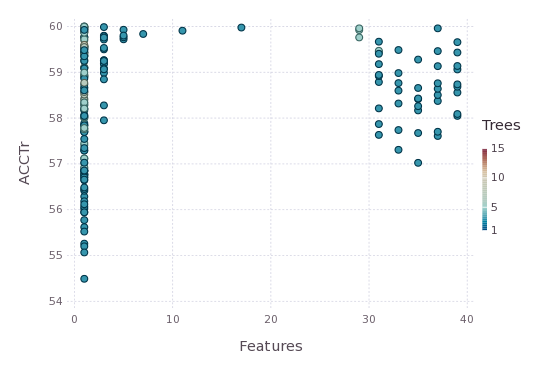

In [153]:
plot((dfLacc[dfLacc[:Trees] .>=2,:])[1:200,:], x="Features", y = "ACCTr", color="Trees")

,Trees,Features,Depth,Leaves,Bootstrap,PCTr,PCTe,RMSETr,RMSETe,ACCTr,ACCTe
1,3,3,50,50,True,0.18389842077556678,0.003462555952051413,0.6387884644350637,0.7058803541775783,59.194929770469344,50.17329255861366
2,3,3,50,45,True,0.18999721027442584,0.002236359643262409,0.6363974488598945,0.7063134539345619,59.4998287084618,50.11213047910296
3,7,1,50,50,True,0.1887391805774414,0.006088603092268015,0.6369624301132788,0.7049410585463616,59.42788626241864,50.30581039755352
4,7,1,50,40,True,0.19151195756274939,-0.011003041726215388,0.6358050252611336,0.7109884578218997,59.57519698526893,49.44954128440367
5,5,1,50,50,True,0.14025399115522527,0.00957308864666642,0.6556471949621484,0.7037108571269369,57.012675573826655,50.479102956167175
6,5,1,50,35,True,0.14821668318590583,-0.004262671904728367,0.6526095927700876,0.7086188487352525,57.41007194244604,49.78593272171254
7,5,1,50,45,True,0.16858823752345098,0.004860435227486383,0.6447936270732033,0.7053747350306586,58.424117848578284,50.24464831804282
8,5,1,50,40,True,0.1871190118354736,-0.0022493354361767786,0.6375269106761261,0.7078992193745022,59.355943816375465,49.88786952089704
9,3,1,50,30,True,0.1341100021548603,-0.007542005616616333,0.6579942947695654,0.7097687380899688,56.70435080507023,49.622833843017325
10,3,1,50,50,True,0.13534144564477896,0.01303986422295835,0.6575255450640567,0.7024785013451954,56.76601575882152,50.652395514780835


In [110]:
dfLacc =(df[df[:ACCTr] .<= 60,:])

,Trees,Features,Depth,Leaves,Bootstrap,PCTr,PCTe,RMSETr,RMSETe,ACCTr,ACCTe
1,1,1,5,15,True,NA,NA,0.7072036716749697,0.7068184015737436,49.98629667694416,50.0407747196738
2,1,1,5,10,True,NA,NA,0.7070098774199987,0.7073950432373257,50.013703323055836,49.959225280326194
3,1,1,15,20,False,NA,NA,0.7070098774199987,0.7073950432373257,50.013703323055836,49.959225280326194
4,1,1,30,15,False,NA,NA,0.7070098774199987,0.7073950432373257,50.013703323055836,49.959225280326194
5,1,1,30,40,False,NA,NA,0.7070098774199987,0.7073950432373257,50.013703323055836,49.959225280326194
6,1,1,40,45,True,NA,NA,0.7070098774199987,0.7073950432373257,50.013703323055836,49.959225280326194
7,1,1,35,40,False,0.01902699927911129,-0.01639203129192506,0.7061856585273416,0.7080432037590634,50.13018156903048,49.867482161060146
8,1,19,5,5,True,0.02636319068635804,-0.009214045967530895,0.7042911587644745,0.7083310847238998,50.39739636861938,49.82670744138634
9,1,1,20,20,True,0.024095007557568854,0.0062360299180360184,0.7042668372187962,0.7066741676366082,50.400822199383356,50.0611620795107
10,1,23,5,30,True,0.02709192810786822,-0.0025124475760477656,0.7029034875275187,0.7077552056980299,50.59266872216512,49.908256880733944


In [111]:
describe(dfLacc)

Trees
Min      1.0
1st Qu.  3.0
Median   15.0
Mean     16.42173738991193
3rd Qu.  27.0
Max      39.0
NAs      0
NA%      0.0%

Features
Min      1.0
1st Qu.  9.0
Median   19.0
Mean     19.094075260208168
3rd Qu.  29.0
Max      39.0
NAs      0
NA%      0.0%

Depth
Min      5.0
1st Qu.  5.0
Median   5.0
Mean     8.423738991192954
3rd Qu.  5.0
Max      50.0
NAs      0
NA%      0.0%

Leaves
Min      5.0
1st Qu.  15.0
Median   30.0
Mean     28.715472377902323
3rd Qu.  40.0
Max      50.0
NAs      0
NA%      0.0%

Bootstrap
Length  9992
Type    ASCIIString
NAs     0
NA%     0.0%
Unique  2

PCTr
Min      0.016016753434030785
1st Qu.  0.11483729876605164
Median   0.13869857854472362
Mean     0.13157895972843556
3rd Qu.  0.15281375143317064
Max      0.20183269191538744
NAs      6
NA%      0.06%

PCTe
Min      -0.032024239613880394
1st Qu.  0.009001155913290074
Median   0.017201098587307888
Mean     0.015539128988660654
3rd Qu.  0.023259517609934995
Max      0.044430396318576246
NAs      6
NA%   

In [170]:
import MLPlots: corrplot

In [169]:
gadfly()

Plots.GadflyBackend()

LoadError: LoadError: UndefVarError: corrpl not defined
while loading In[167], in expression starting on line 1